## **Creating an abnormal industrial equipment sound classification CNN model from scratch**

#### The CNN-based ASD approach presented in this chapter is adapted from the approach provided at https://github.com/SAP-samples/btp-ai-sustainability-bootcamp/blob/main/src/ai-models/predictive-maintenance/notebooks/sound_based_predictive_maintenance.ipynb which is shared under Apache License 2.0 (https://github.com/SAP-samples/btp-ai-sustainability-bootcamp/blob/main/LICENSE).

Note: before running the cell below, make sure that the dataset (zipped file) has been uploaded to Google Drive, Google Drive has been mounted, and the correct path has been specified in the cell below.

In [ ]:
# unzip data folder
!unzip -q -o './drive/MyDrive/AirCompressor_Data.zip' -d './'

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from glob import glob
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns

Now we will prepare data for training and test. Each audio file needs to be converted into its combined spectrogram and MFCC matrix. Let's first assign the health label to each audio file.

In [ ]:
clips = glob('./AirCompressor_Data/*/*') # fetches all the file names
clips_df = pd.DataFrame(data={'path':clips, 'label':[ c.split('/')[-2]  for c in clips]} )

class_dict=dict(enumerate(clips_df.label.unique() ))
classes = {v: k for k, v in class_dict.items()}
clips_df['class']=clips_df['label'].apply(lambda x : classes[x]) # each audio file is assigned a sparse label
clips_df

,path,label,class
0,./AirCompressor_Data/Riderbelt/preprocess_Read...,Riderbelt,0
1,./AirCompressor_Data/Riderbelt/preprocess_Read...,Riderbelt,0
2,./AirCompressor_Data/Riderbelt/preprocess_Read...,Riderbelt,0
3,./AirCompressor_Data/Riderbelt/preprocess_Read...,Riderbelt,0
4,./AirCompressor_Data/Riderbelt/preprocess_Read...,Riderbelt,0
...,...,...,...
1795,./AirCompressor_Data/Bearing/preprocess_Readin...,Bearing,7
1796,./AirCompressor_Data/Bearing/preprocess_Readin...,Bearing,7
1797,./AirCompressor_Data/Bearing/preprocess_Readin...,Bearing,7
1798,./AirCompressor_Data/Bearing/preprocess_Readin...,Bearing,7


The following utility function takes an audio clip and returns its combined acoustic features: log-mel spectrogram and MFCCs

In [ ]:
sr=50000/3

def acoustic_feature_computation(clip):
    data = np.loadtxt(clip, delimiter=',')
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=512, n_mels=64, fmax=sr/2)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    MFCCs=librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40, fmax=sr/2)
    acoustic_features=np.concatenate((MFCCs,log_mel_spectrogram), axis =0)
    return acoustic_features

Below, we assign the audio files to the fitting, validation, and test datasets

In [ ]:
train, test = train_test_split(clips_df, test_size=0.10, random_state=25)
train, validation = train_test_split(train, test_size=0.15, random_state=25)

In [ ]:
# apply the function acoustic_feature_computation to each audio file to generate the  fitting, validation, and test datasets
X_train, X_validation, X_test = [], [], []
y_train, y_validation, y_test = [], [], []

for i,r in train.iterrows(): # Iterate over the DataFrame rows
    X_train.append(acoustic_feature_computation(r['path']))
    y_train.append(r['class'])

for i,r in test.iterrows():
    X_test.append(acoustic_feature_computation(r['path']))
    y_test.append(r['class'])

for i,r in validation.iterrows():
    X_validation.append(acoustic_feature_computation(r['path']))
    y_validation.append(r['class'])

**Build a 2D CNN**

In [ ]:
initializer = tf.keras.initializers.GlorotUniform()

CNNmodel = models.Sequential()

# feature extraction part
CNNmodel.add(layers.Conv2D(32, (4, 4),(2,2), activation='relu', input_shape=(104,98,1), kernel_initializer=initializer))
CNNmodel.add(layers.BatchNormalization())
CNNmodel.add(layers.Conv2D(32, (4, 4),(2,2), activation='relu', kernel_initializer=initializer))
CNNmodel.add(layers.BatchNormalization())
CNNmodel.add(layers.MaxPooling2D((2, 2)))

# classification head
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(512, activation='relu',kernel_initializer=initializer))
CNNmodel.add(layers.Dropout(0.5))
CNNmodel.add(layers.Dense(64, activation='relu',kernel_initializer=initializer))
CNNmodel.add(layers.Dropout(0.5))

# Output
CNNmodel.add(layers.Dense(8, activation='softmax'))

CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 48, 32)        544       
                                                                 
 batch_normalization (Batch  (None, 51, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 23, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 23, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 11, 32)        0         
 D)                                                              
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# compile and fit
CNNmodel.compile(optimizer= "adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
history = CNNmodel.fit(x=np.array(X_train, np.float32), y=np.array(y_train, np.float32),
                       validation_data = (np.array(X_validation, np.float32), np.array(y_validation, np.float32)),
                       epochs=100
                      )

Epoch 1/100
44/44 [==============================] - 7s 25ms/step - loss: 2.7447 - accuracy: 0.1409 - val_loss: 1.9680 - val_accuracy: 0.3169
Epoch 2/100
44/44 [==============================] - 0s 9ms/step - loss: 2.1619 - accuracy: 0.1845 - val_loss: 1.8348 - val_accuracy: 0.2675
Epoch 3/100
44/44 [==============================] - 0s 9ms/step - loss: 2.0106 - accuracy: 0.2121 - val_loss: 1.7488 - val_accuracy: 0.2675
Epoch 4/100
44/44 [==============================] - 0s 9ms/step - loss: 1.8272 - accuracy: 0.2745 - val_loss: 1.4656 - val_accuracy: 0.5062
Epoch 5/100
44/44 [==============================] - 0s 9ms/step - loss: 1.6222 - accuracy: 0.3558 - val_loss: 1.3811 - val_accuracy: 0.5844
Epoch 6/100
44/44 [==============================] - 0s 9ms/step - loss: 1.2261 - accuracy: 0.5178 - val_loss: 0.8089 - val_accuracy: 0.8272
Epoch 7/100
44/44 [==============================] - 0s 8ms/step - loss: 0.9826 - accuracy: 0.5882 - val_loss: 0.7908 - val_accuracy: 0.8765
Epoch 8/100


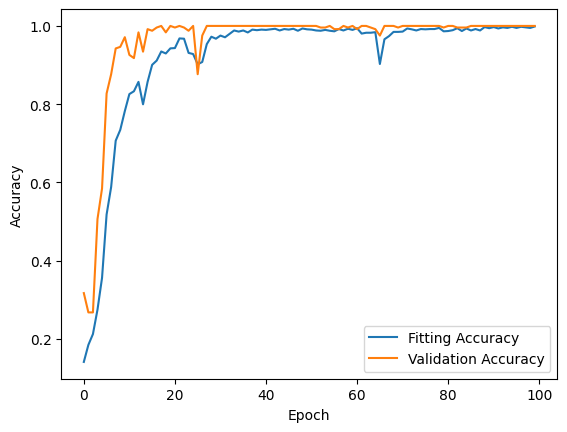

In [ ]:
# plot validation curve
plt.figure()
plt.plot(history.history['accuracy'], label='Fitting Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# check performance on test dataset
score = CNNmodel.evaluate(np.array(X_test, np.float32), np.array(y_test, np.float32))
print('Test accuracy:', score[1])

6/6 [==============================] - 0s 16ms/step - loss: 2.0795e-07 - accuracy: 1.0000
Test accuracy: 1.0


6/6 [==============================] - 1s 4ms/step


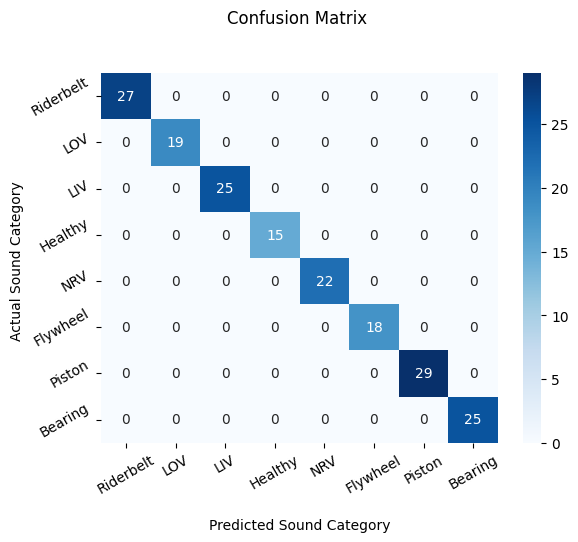

In [ ]:
# plot confusion matrix for test dataset
from sklearn.metrics import confusion_matrix

probs_preds = CNNmodel.predict(np.array(X_test, np.float32)) # each audio file is assigned 8 probabilities corresponding to the 8 health states
pred_class = probs_preds.argmax(axis=1) # numeric class for each audio file
cf_matrix = confusion_matrix(y_test, pred_class)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix \n\n')
ax.set_xlabel('\nPredicted Sound Category')
ax.set_ylabel('Actual Sound Category ')

ax.set_xticklabels(class_dict.values(), rotation=30)
ax.set_yticklabels(class_dict.values(), rotation=30)
plt.show()